In [1]:
import os
import glob as glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import hiddenlayer as hl

In [2]:
# !pip3 install hiddenlayer

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import make_grid


In [4]:
print(os.getcwd())
os.chdir('..')
os.getcwd()


/home/anhnguyen/Documents/GAN/src


'/home/anhnguyen/Documents/GAN'

In [5]:
DATA_DIR = glob.glob(f'animeFaces64')[0]

In [6]:
DATA_DIR

'animeFaces64'

In [7]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
batch_size = 64
image_size = 64
#Training
#Using data data loader, turn every images to Torch Tensor, then normalize by stats
train_ds = ImageFolder(DATA_DIR, transform=transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
    ]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)

In [8]:
#Other preproc and postproc functions:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    # ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break


In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
#Moving the dataloader to GPU
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels of the output image, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
#             self.make_disc_block(hidden_dim, 1, final_layer=True),

        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

<ipython-input-12-e58c2d2eab60>:50: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return disc_pred.view(len(disc_pred), -1)
/home/anhnguyen/.local/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:435: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  warnings.warn("ONNX export mode is set to " + training_mode +


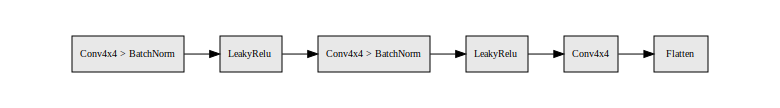

In [13]:
#Test and visualize
# Saving Model
discriminator = Discriminator(im_chan = 3)
temp = torch.rand((1,3,64,64))#.cuda()
discriminator.eval()

traced_script_module = torch.jit.trace(discriminator, temp)

traced_script_module.save("discriminator64.pt")    

hl.build_graph(discriminator, temp)

In [14]:
#Moving discriminator to device
discriminator.to(device)

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 1, kernel_size=(4, 4), stride=(2, 2))
    )
  )
)

In [15]:
#Random input vector
latent_size = 128


In [16]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

<ipython-input-16-13739d7cbcc8>:55: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return noise.view(len(noise), self.z_dim, 1, 1)
/home/anhnguyen/.local/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:435: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  warnings.warn("ONNX export mode is set to " + training_mode +


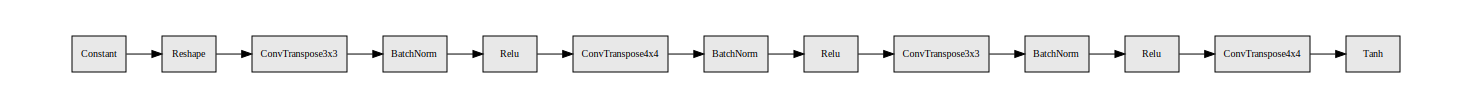

In [17]:
#Test and visualize
# Saving Model
generator = Generator(z_dim = latent_size, im_chan = 3)
temp = torch.rand((1,latent_size,1,1))
generator.eval()

traced_script_module = torch.jit.trace(generator, temp)

traced_script_module.save("generator64.pt")    

hl.build_graph(generator, temp)

torch.Size([64, 3, 28, 28])


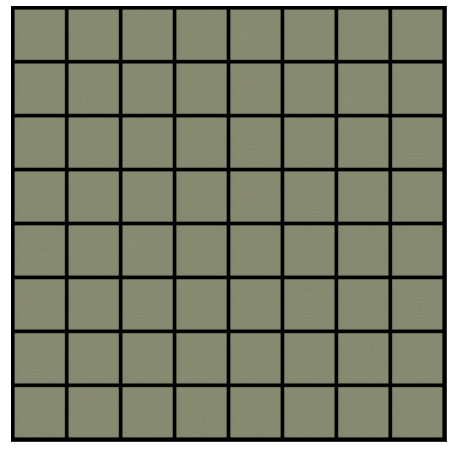

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [19]:
#Moving generator to device
generator = to_device(generator, device)


In [20]:
#Criterion
criterion = nn.BCEWithLogitsLoss()

In [21]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones_like(real_preds)
    real_loss = criterion(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros_like(fake_preds)
    fake_loss = criterion(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [22]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones_like(preds)
    loss = criterion(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [23]:
from torchvision.utils import save_image
sample_dir = 'generated_64'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


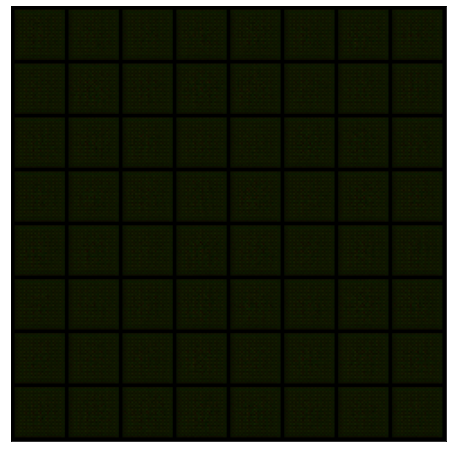

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)


In [25]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

lr = 0.0005
epochs = 25

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [26]:
history = fit(epochs, lr)
losses_g, losses_d, real_scores, fake_scores = history


# Save the model checkpoints 
torch.save(generator.state_dict(), 'G_64.pth')
torch.save(discriminator.state_dict(), 'D_64.pth')


Epoch [1/25], loss_g: 1.0031, loss_d: 1.2586, real_score: -0.0356, fake_score: -0.4115
Saving generated-images-0001.png



Epoch [2/25], loss_g: 0.9793, loss_d: 1.3074, real_score: -0.2390, fake_score: -0.4853
Saving generated-images-0002.png



Epoch [3/25], loss_g: 0.7675, loss_d: 1.4283, real_score: -0.0588, fake_score: -0.1183
Saving generated-images-0003.png



Epoch [4/25], loss_g: 1.1747, loss_d: 0.9694, real_score: 1.4634, fake_score: -0.4627
Saving generated-images-0004.png



Epoch [5/25], loss_g: 0.9624, loss_d: 0.9662, real_score: 1.2499, fake_score: -0.2178
Saving generated-images-0005.png



Epoch [6/25], loss_g: 1.1004, loss_d: 1.2032, real_score: 0.8832, fake_score: -0.5347
Saving generated-images-0006.png



Epoch [7/25], loss_g: 1.2733, loss_d: 1.4026, real_score: 0.1043, fake_score: -0.0136
Saving generated-images-0007.png



Epoch [8/25], loss_g: 0.9067, loss_d: 1.1671, real_score: 1.9327, fake_score: -0.1579
Saving generated-images-0008.png



Epoch [9/25], loss_g: 0.9221, loss_d: 1.3737, real_score: 1.5017, fake_score: 0.2313
Saving generated-images-0009.png



Epoch [10/25], loss_g: 1.0477, loss_d: 1.2219, real_score: 0.3965, fake_score: -0.6472
Saving generated-images-0010.png



Epoch [11/25], loss_g: 1.0570, loss_d: 0.8109, real_score: 1.5233, fake_score: -0.4461
Saving generated-images-0011.png



Epoch [12/25], loss_g: 1.2236, loss_d: 1.1431, real_score: 0.3512, fake_score: -0.8205
Saving generated-images-0012.png



Epoch [13/25], loss_g: 1.4331, loss_d: 1.1088, real_score: 0.4116, fake_score: -0.8153
Saving generated-images-0013.png



Epoch [14/25], loss_g: 1.3275, loss_d: 1.0754, real_score: 0.6127, fake_score: -0.7304
Saving generated-images-0014.png



Epoch [15/25], loss_g: 3.0917, loss_d: 1.3044, real_score: 0.2624, fake_score: -0.7191
Saving generated-images-0015.png



Epoch [16/25], loss_g: 1.1061, loss_d: 0.8176, real_score: 3.4016, fake_score: -0.5174
Saving generated-images-0016.png



Epoch [17/25], loss_g: 0.9358, loss_d: 1.2034, real_score: 1.1597, fake_score: 0.2284
Saving generated-images-0017.png



Epoch [18/25], loss_g: 0.8751, loss_d: 0.9556, real_score: 1.4352, fake_score: -0.2562
Saving generated-images-0018.png



Epoch [19/25], loss_g: 1.1349, loss_d: 0.8608, real_score: 4.4382, fake_score: -0.5434
Saving generated-images-0019.png



Epoch [20/25], loss_g: 1.2663, loss_d: 0.9163, real_score: 1.7417, fake_score: -0.9864
Saving generated-images-0020.png



Epoch [21/25], loss_g: 1.4864, loss_d: 0.9755, real_score: 1.6190, fake_score: -0.8473
Saving generated-images-0021.png



Epoch [22/25], loss_g: 1.4341, loss_d: 0.5329, real_score: 5.7977, fake_score: -1.1051
Saving generated-images-0022.png



Epoch [23/25], loss_g: 0.7900, loss_d: 1.3510, real_score: -0.1162, fake_score: -0.5382
Saving generated-images-0023.png



Epoch [24/25], loss_g: 1.0425, loss_d: 1.1138, real_score: 0.9604, fake_score: -0.3351
Saving generated-images-0024.png



Epoch [25/25], loss_g: 0.7435, loss_d: 1.4952, real_score: 0.3774, fake_score: 0.3656
Saving generated-images-0025.png


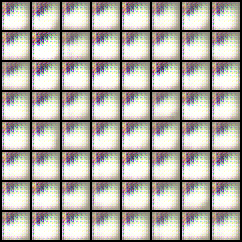

In [27]:
from IPython.display import Image
Image('./generated_64/generated-images-0001.png')


In [28]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

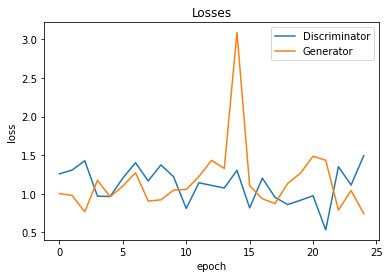

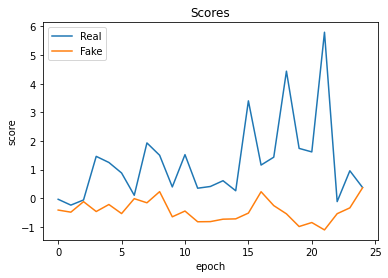

In [29]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.show()
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');
plt.show()